Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


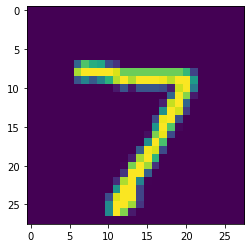

In [3]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

# Y 0 0 0 0 0 0 0 0 0 0
#                     1
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
sess = tf.Session()

# 784로 이미지 저장
image  = tf.reshape ( mnist.test.images[0:5] , [-1, 28,28])

# 전치를 시키는 이유: 채널 분리를 막기 위해 (이미지 제대로 안나올 때 해결법)
channel = tf.transpose ( image[0], perm= [ 0,1]) 

np_list = sess.run(channel )
plt.imshow(np_list)
plt.show()

 

In [ ]:

with tf.Session() as sess:
    first_image = mnist.test.images[0]
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()
   

learning_rate = 0.001

# epoch
num_steps = 500

# 한번에 입력되는 사이즈: 지역해 문제 해결법
batch_size = 128
display_step = 10

num_input = 784
num_classes = 10

# fully-connected로 연산 시 과적합(랜덤하게 일부회로 제거하더라도 모델 역할 가능)
dropout = 0.75

# 784 1차 이미지를 여러장 받겠다 
X = tf.placeholder(tf.float32, [None, num_input])

# one-hot-encoding 되어 있어서, 2차원으로 받음
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)


# tf.nn.conv2d를 waap
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

   
def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])   #28x28x32
    conv1 = maxpool2d(conv1, k=2)   # 14x14x32
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2']) #14x14x64
    conv2 = maxpool2d(conv2, k=2) # 7x7x64


    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]]) #7x7x64
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1']) #1024
    fc1 = tf.nn.relu(fc1)

    fc1 = tf.nn.dropout(fc1, dropout)
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out']) #10
    return out


weights = { # 가중치를 계산해서 결정  dense를 사용 
    
    # cnn 특성추출을 위한 가중치
    # 필터 사이즈 5x5 입력1개, 출력 32
    # 이미지 특성추출 모양 유지(가로, 세로)
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    
    # 입력 32 아웃풋 64
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    
    # 분류를 위한 가중치
    # 7*7*64 flatten, 1024 중간 축약
    # 이미지 사이즈가 28x28 -> 7x7바뀜 특성이 64장으로 바뀜
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

 

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

 

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))

# 대용량 데이터를 다뤄야 하기에 잘게 나누어 놓음
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variables가 있을 경우, 반드시 호출 - GPU사용전제 
init = tf.global_variables_initializer()

# session은 네트워크: GPU 사용을 위해
with tf.Session() as sess:
    # 실행. 결과가  numpy로 출력
    sess.run(init)
    
    # epoch
    for step in range(1, num_steps+1):
        
        # 동시에 여러개 값 리턴 가능
        batch_x, batch_y = mnist.train.next_batch(batch_size)

        # train_op 그라프의 하부구조가 다 되어야 결과값 출력 가능
        # train_op에서 다 계산되었기 때문에, 단순 호출 (마지막 변수 호출)
        # placeholder 있을 경우, feed_dict 사용
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        
        # step일 때 한번 출력 및 조건 출력 
        if step % display_step == 0 or step == 1:

            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
    
    # 과적합 체크 (test 값 출력해 봄)
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0}))
